# Linear Regression with TensorFlow

This notebook elaborates on the gradient descent I've used to conduct linear regression by using the tensorFlow library to create and tune a linear model.

### Import libraries

In [3]:
# %pip install keras-tuner

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
import keras_tuner as kt
from keras_tuner import HyperParameters

---
###  Data ingestion

For this exercise we will use the automobile dataset from the UCI ML repository:

In [5]:
# columns don't come in the dataset so we use the readme to add them in.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']


car_data_init = pd.read_csv(
    'https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
    sep=',', names=cols, header=None, encoding='latin-1')

car_data_init.head()

,symboling,losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


---
###  Data preprocessing

### <span style="color:chocolate"></span> Column selection

In [7]:
car_data = car_data_init[['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']]
car_data = car_data.apply(pd.to_numeric, errors='coerce')
car_data = car_data.dropna() # remove nulls
print(car_data.dtypes)

horsepower     float64
peak-rpm       float64
city-mpg         int64
highway-mpg      int64
price          float64
dtype: object


### <span style="color:chocolate"></span> Data shuffling

Batch gradient descent requires us to shuffle the data so that there's accurate representation for each batch:

In [8]:
np.random.seed(0)
indices = car_data.index.to_list()
shuffled_indices = np.random.permutation(indices)
car_data = car_data.reindex(shuffled_indices)
car_data.head()

,horsepower,peak-rpm,city-mpg,highway-mpg,price
19,70.0,5400.0,38,43,6295.0
175,92.0,4200.0,27,32,9988.0
109,97.0,5000.0,19,24,12440.0
95,69.0,5200.0,31,37,7799.0
182,52.0,4800.0,37,46,7775.0


### Split into Response and Features

In [10]:
Y = car_data['price']
X = car_data[['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']] #or X = car_data.drop(columns=['price'])
print(Y.shape)
print(X.shape)

(199,)
(199, 4)


### <span style="color:chocolate"></span> Data splits

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=1234)

### <span style="color:chocolate"></span> Data standardization

In [12]:
# xi - mu(x) / sd(x)

X_train_std = (X_train - X_train.mean()) / X_train.std()
X_val_std = (X_val - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_train.mean()) / X_train.std()

print(X_train_std.head())
print(X_val_std.head())
print(X_test_std.head())

     horsepower  peak-rpm  city-mpg  highway-mpg
97    -0.832610  0.253968  0.826269     0.832064
154   -1.020060 -0.628431  0.197988     0.095341
63    -0.966503 -0.959331  1.611621     1.568786
161   -0.805831 -0.628431  0.355058     0.390030
140   -0.725496 -1.510830  0.040917    -0.052004
     horsepower  peak-rpm  city-mpg  highway-mpg
40    -0.377375  1.577566  0.197988     0.242685
192   -0.859388 -1.290231  1.140410     0.979408
118   -0.859388  0.915767  1.768691     1.421442
122   -0.859388  0.915767  0.826269     0.979408
113   -0.136368 -0.187232 -1.058575    -1.083416
     horsepower  peak-rpm  city-mpg  highway-mpg
120   -0.859388  0.915767  0.826269     0.979408
117    1.122223  1.136367 -1.215645    -1.083416
58     0.934773  2.018766 -1.529786    -1.230761
101    1.390008  0.253968 -1.372716    -1.378105
20    -0.805831  0.695167  1.925762     1.716131


In [14]:
# same thing with the response variable

Y_train_std = (Y_train - Y_train.mean()) / Y_train.std()
Y_val_std = (Y_val - Y_train.mean()) / Y_train.std()
Y_test_std = (Y_test - Y_train.mean()) / Y_train.std()

print(Y_train_std.head())
print(Y_val_std.head())
print(Y_test_std.head())

97    -0.599914
154   -0.612305
63    -0.256896
161   -0.555871
140   -0.648496
Name: price, dtype: float64
40    -0.318237
192    0.117283
118   -0.897662
122   -0.647760
113    0.466925
Name: price, dtype: float64
120   -0.817060
117    0.645427
58     0.338109
101    0.074835
20    -0.774613
Name: price, dtype: float64


---
###  Exploratory data analysis (EDA)

### <span style="color:chocolate"></span> Scatterplot matrix

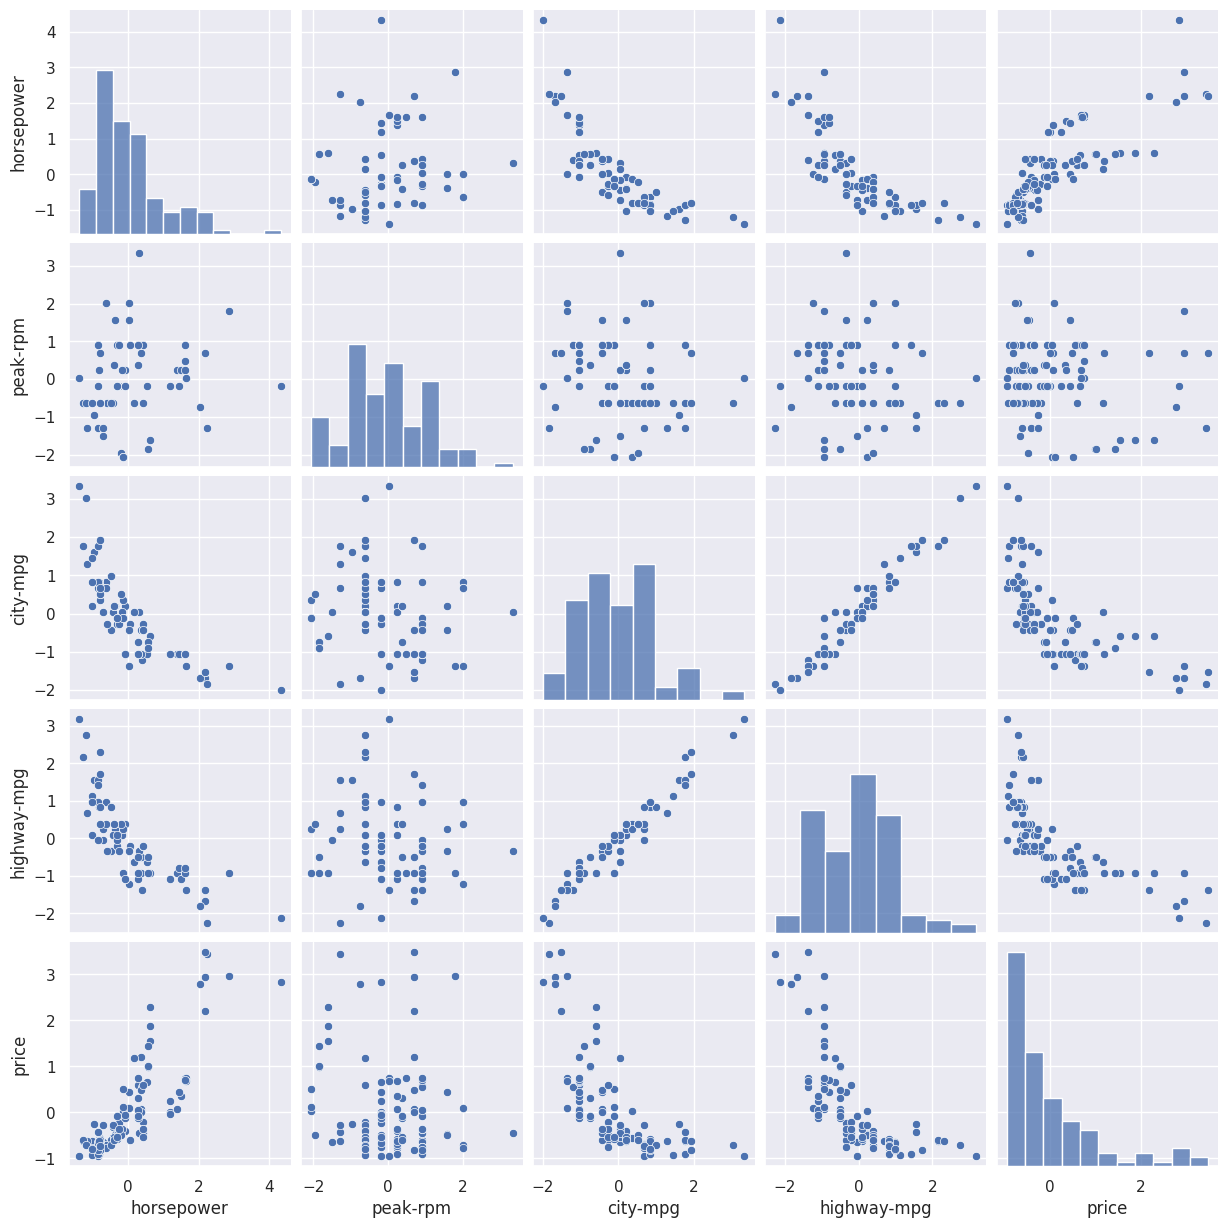

In [15]:
# see which variables are correlated to each other enough to remove one of them to prevent colinearity
sns.pairplot(pd.concat([X_train_std, Y_train_std], axis=1))

### <span style="color:chocolate"></span> Correlation matrix

<Axes: >

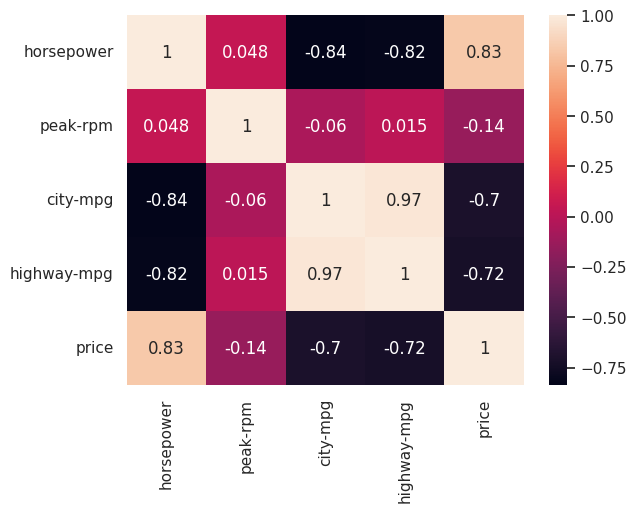

In [16]:
# correlation map to see which features to remove
sns.heatmap(pd.concat([X_train_std, Y_train_std], axis=1).corr(), annot=True)

---
###  Modeling

### <span style="color:chocolate"></span> Baseline model

our baseline will be the mean as a predictor:

In [ ]:
avg_price = Y_train_std.mean()
print("average price standardized:", avg_price)
print("average price:", Y_train.mean())

mse_baseline = ((Y_test_std - avg_price) ** 2).mean()
print("mse baseline:", mse_baseline)

average price standardized: 7.556980251650225e-17
average price: 12889.008403361344
mse baseline: 0.6004037961662304


### <span style="color:chocolate"></span> Improvement over Baseline with TensorFlow

In [17]:
def build_model(num_features: int, learning_rate: float) -> tf.keras:
  # clear session to avoid models persisting during experimentation
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(units=1, input_shape=(num_features,), use_bias=True, kernel_initializer=tf.keras.initializers.Ones(),bias_initializer=tf.keras.initializers.Ones(),))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss='mean_squared_error', optimizer=optimizer)

  return model

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 5.5000 - val_loss: 4.8144
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4840 - val_loss: 4.8031
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4681 - val_loss: 4.7919
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4523 - val_loss: 4.7808
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4365 - val_loss: 4.7696


Text(0, 0.5, 'Loss (MSE)')

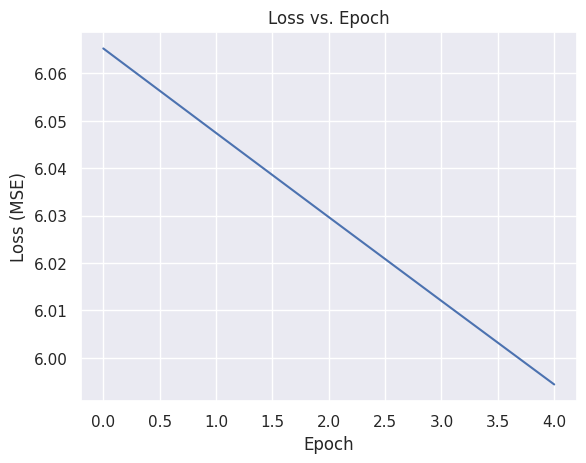

In [19]:
tf.random.set_seed(0)
model_tf = build_model(num_features=X_train_std.shape[1], learning_rate=0.0001)
model_tf_fit = model_tf.fit(X_train_std, Y_train_std, epochs=5, validation_data=(X_val_std, Y_val_std))
losses = model_tf_fit.history['loss']
epochs = model_tf_fit.epoch
sns.lineplot(y=losses, x=epochs)
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")

---
###  Hyperparameter tuning

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Text(0, 0.5, 'Loss (MSE)')

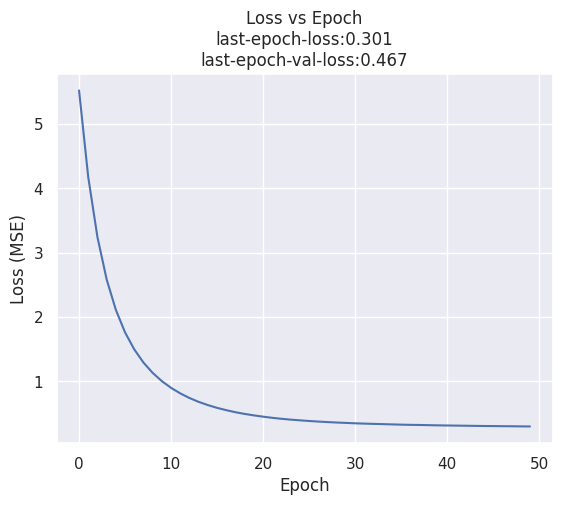

In [20]:
tf.random.set_seed(0)
# 2. Build and compile model
model_tf = build_model(num_features=X_train_std.shape[1], learning_rate=0.01)

# 3. Fit the model
model_tf_fit = model_tf.fit(X_train_std, Y_train_std, epochs=50, validation_data=(X_val_std, Y_val_std), verbose=0)
losses = model_tf_fit.history['loss']
val_losses = model_tf_fit.history['val_loss']
losses = [round(l,3) for l in losses]
val_losses = [round(v,3) for v in val_losses]
epochs = model_tf_fit.epoch
sns.lineplot(y=losses, x=epochs)
plt.title(f"Loss vs Epoch\nlast-epoch-loss:{losses[-1]}\nlast-epoch-val-loss:{val_losses[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")

---
###  Evaluation and Generalization

### <span style="color:chocolate"></span> Computing MSE

In [21]:
train_mse = model_tf.evaluate(X_train_std, Y_train_std)
test_mse = model_tf.evaluate(X_test_std, Y_test_std)
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2741
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3060 
Train MSE: 0.29906463623046875
Test MSE: 0.30006223917007446


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Text(0, 0.5, 'Predicted Y-values')

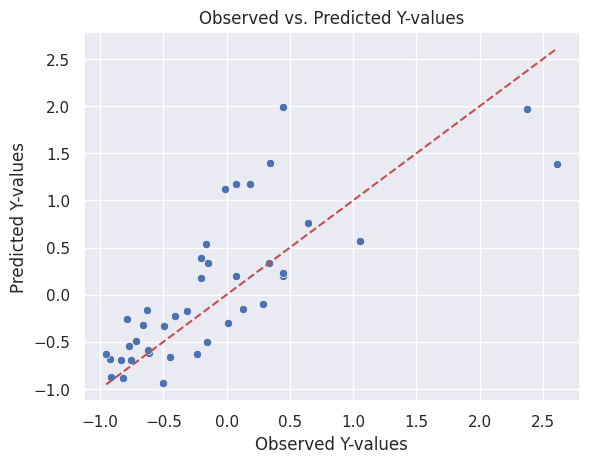

In [22]:
predicted_Y_test = model_tf.predict(X_test_std).reshape(-1)
sns.scatterplot(x=Y_test_std, y=predicted_Y_test)
plt.plot([Y_test_std.min(), Y_test_std.max()], [Y_test_std.min(), Y_test_std.max()], 'r--')
plt.title("Observed vs. Predicted Y-values")
plt.xlabel("Observed Y-values")
plt.ylabel("Predicted Y-values")